## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import datetime as dt
import re

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 500)
%matplotlib inline

## Read data

In [2]:
admin = pd.read_csv('../AirTracks/all_csv/Jan2017/admin.csv')

In [3]:
admin.head()

,FlightId,FlightCallsign,AircraftModel,AircraftRegistration,Airline,Origin,Destination,SchdeuledDeparture,ScheduledArrival,RealDeparture,EstimatedArrival,FlightTime
0,c244ac4,SAS1749,ATR 72-600,OY-JZE,SAS,Tallinn Lennart Meri Airport,Stockholm Arlanda Airport,1.484156e+09,1.484161e+09,1.484159e+09,NaN,3762.0
1,c32d217,OKA2925,Boeing 737-8AS,B-5578,OKAir,Changsha Huanghua International Airport,Hangzhou Xiaoshan International Airport,1.484694e+09,1.484698e+09,1.484694e+09,1.484698e+09,3850.0
2,c326787,TAR713,Airbus A320-214,TS-IMW,Tunisair,Tunis Carthage International Airport,Jeddah King Abdulaziz International Airport,1.484678e+09,1.484694e+09,1.484681e+09,1.484695e+09,13929.0
3,c35d480,RYR71SN,Boeing 737-8AS,EI-FRJ,Ryanair,Madrid Barajas Airport,Brussels South Charleroi Airport,1.484804e+09,1.484813e+09,1.484805e+09,1.484813e+09,7154.0
4,c3705bd,BSX844,Airbus A320-214,XU-112,Bassaka Air,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN


## Rename columns

In [4]:
admin.rename(columns={
    'FlightId': 'flight_id',
    'FlightCallsign': 'flight_callsign',
    'AircraftModel': 'aircraft_model',
    'AircraftRegistration': 'aircraft_registration',
    'SchdeuledDeparture': 'scheduled_departure_utc',
    'ScheduledArrival': 'scheduled_arrival_utc',
    'RealDeparture': 'real_departure_utc',
    'EstimatedArrival': 'estimated_arrival_utc',
    'FlightTime': 'real_flight_duration'
     }, inplace=True)

admin.columns = admin.columns.map(lambda x: x.lower())

In [5]:
str_cols = admin.columns[admin.dtypes==object]

**Handle data of object type**

In [6]:
# Fill NaN with empty string
admin[str_cols] = admin[str_cols].fillna('')

In [7]:
# Strip leading and trailing spaces in object columns
admin[str_cols] = admin[str_cols].apply(lambda x: x.str.strip())

## Convert to datetime

In [8]:
# def get_utc_datetime(value):
#     try:
#         return dt.datetime.fromtimestamp(value)
#     except:
#         return pd.NaT
    
# admin['scheduled_departure_dt'] = admin['scheduled_departure_utc'].map(get_utc_datetime)
# admin['scheduled_arrival_dt'] = admin['scheduled_arrival_utc'].map(get_utc_datetime)
# admin['real_departure_dt'] = admin['real_departure_utc'].map(get_utc_datetime)
# admin['estimated_arrival_dt'] = admin['estimated_arrival_utc'].map(get_utc_datetime)

admin['scheduled_departure_dt'] = pd.to_datetime(admin['scheduled_departure_utc'], unit='s')
admin['scheduled_arrival_dt'] = pd.to_datetime(admin['scheduled_arrival_utc'], unit='s')
admin['real_departure_dt'] = pd.to_datetime(admin['real_departure_utc'], unit='s')
admin['estimated_arrival_dt'] = pd.to_datetime(admin['estimated_arrival_utc'], unit='s')

Observation: There are some dates where year = 1970. Check if there are dates that do not fall within Jan 2017

In [9]:
# admin['scheduled_arrival_year'] = admin['scheduled_arrival_dt'].dt.year.astype('Int64')
# admin['scheduled_arrival_month'] = admin['scheduled_arrival_dt'].dt.month.astype('Int64')
# admin['scheduled_arrival_day'] = admin['scheduled_arrival_dt'].dt.day.astype('Int64')

# admin['scheduled_departure_year'] = admin['scheduled_departure_dt'].dt.year.astype('Int64')
# admin['scheduled_departure_month'] = admin['scheduled_departure_dt'].dt.month.astype('Int64')
# admin['scheduled_departure_day'] = admin['scheduled_departure_dt'].dt.day.astype('Int64')

In [10]:
# admin['scheduled_arrival_dt'].dt.year.value_counts(dropna=False).sort_index()

In [11]:
scheduled_arrival_missing_index = admin.loc[admin['scheduled_arrival_dt'].isnull(), 'scheduled_arrival_dt'].index.tolist()
scheduled_departure_missing_index = admin.loc[admin['scheduled_departure_dt'].isnull(), 'scheduled_departure_dt'].index.tolist()
estimated_arrival_missing_index = admin.loc[admin['estimated_arrival_dt'].isnull(), 'estimated_arrival_dt'].index.tolist()
real_departure_missing_index = admin.loc[admin['real_departure_dt'].isnull(), 'real_departure_dt'].index.tolist()

In [12]:
print(len(scheduled_departure_missing_index))
print(len(scheduled_arrival_missing_index))
print(np.array_equal(scheduled_departure_missing_index, scheduled_arrival_missing_index))

23538
23538
True


**Observation: Rows with NaT for scheduled_arrival_dt also had NaT for scheduled_departure_dt**

In [13]:
print(len(estimated_arrival_missing_index))
print(len(list(set(estimated_arrival_missing_index).intersection(set(scheduled_departure_missing_index)))))

502967
23538


**Observation: EstimatedArrival shares common missing values for ScheduledArrival and ScheduledDeparture**

In [14]:
print(len(estimated_arrival_missing_index))
print(len(real_departure_missing_index))

502967
64318


In [15]:
print(np.array_equal(estimated_arrival_missing_index, real_departure_missing_index))
print(len(list(set(real_departure_missing_index).intersection(set(estimated_arrival_missing_index)))))

False
54251


**Observation: RealDeparture has 54251 common missing values with EstimatedArrival**

In [16]:
# admin['scheduled_flight_duration'] = admin['scheduled_arrival_utc'] - admin['scheduled_departure_utc']

In [17]:
# def cast_zero_to_nan(val):
#     if int(val) == 0:
#         return np.nan
#     else:
#         return val
    
# admin['scheduled_flight_duration'] = admin['scheduled_flight_duration'].map(cast_zero_to_nan)

**real_departure**

In [18]:
admin['real_departure_dt'].dt.year.value_counts(dropna=False)

2017.0    1084480
NaN         64318
2016.0       9329
Name: real_departure_dt, dtype: int64

In [19]:
# admin.dropna(subset=['real_departure_dt'], inplace=True)

**real_flight_duration**

In [20]:
# (admin['estimated_arrival'] - admin['real_departure'])[1].total_seconds()
(admin['estimated_arrival_utc'] - admin['real_departure_utc'])[1]

4135.0

In [21]:
admin['real_flight_duration'].isnull().sum()

160380

In [22]:
real_flight_duration_null_idx = admin[admin['real_flight_duration'].isnull()].index.tolist()
real_departure_null_idx = admin[admin['real_departure_utc'].isnull()].index.tolist()

In [23]:
print(len(real_flight_duration_null_idx))
print(len(real_departure_null_idx))
print(len(set(real_flight_duration_null_idx).intersection(real_departure_null_idx)))

160380
64318
40619


## Route

In [24]:
admin['route'] = admin.origin + " -> " + admin.destination

In [25]:
admin['route'].value_counts()[:20]

 ->                                                                                              35666
Seoul Gimpo International Airport -> Jeju International Airport                                   2058
Jeju International Airport -> Seoul Gimpo International Airport                                   1971
Sydney Kingsford Smith Airport -> Melbourne Airport                                               1554
Ho Chi Minh City International Airport -> Hanoi Noi Bai International Airport                     1466
Melbourne Airport -> Sydney Kingsford Smith Airport                                               1454
Hanoi Noi Bai International Airport -> Ho Chi Minh City International Airport                     1402
Delhi Indira Gandhi International Airport -> Mumbai Chhatrapati Shivaji International Airport     1233
Mumbai Chhatrapati Shivaji International Airport -> Delhi Indira Gandhi International Airport     1195
Dubai International Airport ->                                           

In [26]:
admin.isnull().sum()

flight_id                       0
flight_callsign                 0
aircraft_model                  0
aircraft_registration           0
airline                         0
origin                          0
destination                     0
scheduled_departure_utc     23538
scheduled_arrival_utc       23538
real_departure_utc          64318
estimated_arrival_utc      502967
real_flight_duration       160380
scheduled_departure_dt      23538
scheduled_arrival_dt        23538
real_departure_dt           64318
estimated_arrival_dt       502967
route                           0
dtype: int64

## Arrivals at Hong Kong International Airport

In [27]:
df_arrivals_at_hkg = admin[admin['destination'] == 'Hong Kong International Airport']
df_arrivals_at_hkg.reset_index(inplace=True, drop=True)
df_arrivals_at_hkg.head(2)

,flight_id,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,route
0,c37d285,CAL680,Airbus A330-302,B-18302,China Airlines,Jakarta Soekarno Hatta International Airport,Hong Kong International Airport,1.484869e+09,1.484885e+09,1.484871e+09,NaN,15588.0,2017-01-19 23:35:00,2017-01-20 04:10:00,2017-01-20 00:01:56,NaT,Jakarta Soekarno Hatta International Airport -...
1,c1774c7,CPA3259,Boeing 747-467F(ER),B-LID,Cathay Pacific Cargo,Shanghai Pudong International Airport,Hong Kong International Airport,1.483675e+09,1.483685e+09,1.483677e+09,NaN,7960.0,2017-01-06 03:50:00,2017-01-06 06:50:00,2017-01-06 04:21:57,NaT,Shanghai Pudong International Airport -> Hong ...


In [28]:
df_arrivals_at_hkg.shape

(14007, 17)

In [29]:
df_arrivals_at_hkg[df_arrivals_at_hkg['real_departure_dt'].isnull()].shape

(92, 17)

In [30]:
# df_arrivals_at_hkg.dropna(subset=['real_departure_dt'], inplace=True)

In [31]:
len(df_arrivals_at_hkg['flight_id'].unique())

14007

In [32]:
df_arrivals_at_hkg['scheduled_arrival_dt'].value_counts().sort_index()

1970-01-01 00:00:00    594
2016-12-31 13:15:00      1
2016-12-31 15:30:00      1
2016-12-31 15:35:00      2
2016-12-31 15:55:00      2
                      ... 
2017-01-31 22:40:00      1
2017-01-31 22:50:00      1
2017-01-31 22:55:00      2
2017-01-31 23:00:00      1
2017-02-01 00:05:00      1
Name: scheduled_arrival_dt, Length: 6165, dtype: int64

**Deal with rows with dates that are in 1970**

In [33]:
df_arrivals_at_hkg.loc[df_arrivals_at_hkg['scheduled_arrival_dt'].dt.year == 1970, 'real_departure_dt'].isnull().sum()

18

In [34]:
def replace_with_NaT(val):
    if val.year == 1970:
        return pd.NaT
    else:
        return val

In [35]:
df_arrivals_at_hkg['scheduled_departure_dt'] = df_arrivals_at_hkg['scheduled_departure_dt'].map(replace_with_NaT)
df_arrivals_at_hkg['scheduled_departure_dt'].dt.year.value_counts(dropna=False).sort_index()

2016.0      155
2017.0    13247
NaN         605
Name: scheduled_departure_dt, dtype: int64

In [36]:
df_arrivals_at_hkg['scheduled_arrival_dt'] = df_arrivals_at_hkg['scheduled_arrival_dt'].map(replace_with_NaT)
df_arrivals_at_hkg['scheduled_arrival_dt'].dt.year.value_counts(dropna=False).sort_index()

2016.0       71
2017.0    13331
NaN         605
Name: scheduled_arrival_dt, dtype: int64

In [37]:
df_arrivals_at_hkg['real_departure_dt'].dt.year.value_counts(dropna=False).sort_index()

2016.0      152
2017.0    13763
NaN          92
Name: real_departure_dt, dtype: int64

In [38]:
df_arrivals_at_hkg['estimated_arrival_dt'].dt.year.value_counts(dropna=False).sort_index()

2016.0      33
2017.0    5646
NaN       8328
Name: estimated_arrival_dt, dtype: int64

**Convert back to UTC**

In [39]:
df_arrivals_at_hkg['scheduled_arrival_utc'] = (df_arrivals_at_hkg['scheduled_arrival_dt'] - dt.datetime(1970,1,1)).dt.total_seconds()
df_arrivals_at_hkg['scheduled_departure_utc'] = (df_arrivals_at_hkg['scheduled_departure_dt'] - dt.datetime(1970,1,1)).dt.total_seconds()

In [40]:
df_arrivals_at_hkg['scheduled_flight_duration'] = df_arrivals_at_hkg['scheduled_arrival_utc'] - df_arrivals_at_hkg['scheduled_departure_utc']
df_arrivals_at_hkg['scheduled_flight_duration'].head()

0    16500.0
1    10800.0
2        NaN
3    15900.0
4     8700.0
Name: scheduled_flight_duration, dtype: float64

In [41]:
# (df_arrivals_at_hkg['scheduled_arrival_dt'] - df_arrivals_at_hkg['scheduled_departure_dt']).dt.total_seconds()

In [42]:
df_arrivals_at_hkg['scheduled_flight_duration'] = df_arrivals_at_hkg.groupby("origin")['scheduled_flight_duration'].transform(lambda x: x.fillna(x.median()))
df_arrivals_at_hkg['real_flight_duration'] = df_arrivals_at_hkg.groupby("origin")['real_flight_duration'].transform(lambda x: x.fillna(x.median()))

In [43]:
df_arrivals_at_hkg['estimated_arrival_dt'].isnull().sum()

8328

**Using estimated arrival as benchmark**

In [44]:
# (df_arrivals_at_hkg['estimated_arrival_dt'].fillna(df_arrivals_at_hkg['real_departure_dt'] + 
#                                                    pd.to_timedelta(df_arrivals_at_hkg['real_flight_duration'], unit='s'))).isnull().sum()

In [45]:
# replace estimated arrival
df_arrivals_at_hkg['estimated_arrival_dt'] = \
df_arrivals_at_hkg['estimated_arrival_dt']\
.fillna(df_arrivals_at_hkg['real_departure_dt'] + pd.to_timedelta(df_arrivals_at_hkg['real_flight_duration'], unit='s'))\
.fillna(df_arrivals_at_hkg['real_departure_dt'] + pd.to_timedelta(df_arrivals_at_hkg['scheduled_flight_duration'], unit='s'))\
.fillna(df_arrivals_at_hkg['scheduled_arrival_dt'])\
.fillna(df_arrivals_at_hkg['scheduled_departure_dt'] + pd.to_timedelta(df_arrivals_at_hkg['real_flight_duration'], unit='s'))

In [46]:
df_arrivals_at_hkg['estimated_arrival_dt'].isnull().sum()

101

**Using real departure as benchmark**

In [47]:
df_arrivals_at_hkg['forecasted_arrival_dt'] = \
(df_arrivals_at_hkg['real_departure_dt'] + pd.to_timedelta(df_arrivals_at_hkg['real_flight_duration'], unit='s'))\
.fillna(df_arrivals_at_hkg['real_departure_dt'] + pd.to_timedelta(df_arrivals_at_hkg['scheduled_flight_duration'], unit='s'))\
.fillna(df_arrivals_at_hkg['scheduled_departure_dt'] + pd.to_timedelta(df_arrivals_at_hkg['real_flight_duration'], unit='s'))\
.fillna(df_arrivals_at_hkg['scheduled_arrival_dt'])\
.fillna(df_arrivals_at_hkg['estimated_arrival_dt'])

In [48]:
df_arrivals_at_hkg['forecasted_arrival_dt'].isnull().sum()

101

In [49]:
# remove records where forecasted_arrival_dt is null
df_arrivals_at_hkg = df_arrivals_at_hkg[~df_arrivals_at_hkg['forecasted_arrival_dt'].isnull()]

In [50]:
df_arrivals_at_hkg.shape

(13906, 19)

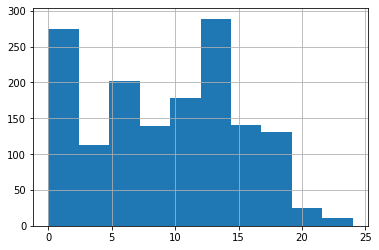

In [51]:
df_arrivals_per_30_min = df_arrivals_at_hkg.set_index('forecasted_arrival_dt').resample('30Min').count().reset_index()\
[['forecasted_arrival_dt', 'flight_id']]
df_arrivals_per_30_min.rename(columns={'flight_id': 'arrivals'}, inplace=True)
df_arrivals_per_30_min.set_index('forecasted_arrival_dt', inplace=True)
df_arrivals_per_30_min['arrivals'].hist()

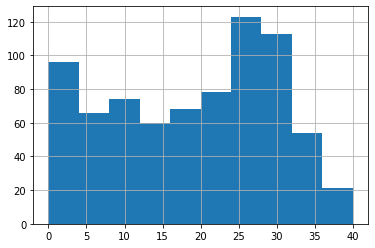

In [52]:
df_arrivals_per_60_min = df_arrivals_at_hkg.set_index('forecasted_arrival_dt').resample('60Min').count().reset_index()\
[['forecasted_arrival_dt', 'flight_id']]
df_arrivals_per_60_min.rename(columns={'flight_id': 'arrivals'}, inplace=True)
df_arrivals_per_60_min.set_index('forecasted_arrival_dt', inplace=True)
df_arrivals_per_60_min['arrivals'].hist()

In [53]:
df_arrivals_at_hkg['forecasted_arrival_dt_nearest_hr'] = df_arrivals_at_hkg['forecasted_arrival_dt'].apply(lambda x: dt.datetime(x.year, x.month, x.day, x.hour,60*(x.minute // 60)))
df_arrivals_at_hkg['forecasted_arrival_dt_nearest_hr'].head()

0   2017-01-20 04:00:00
1   2017-01-06 06:00:00
2   2017-01-03 09:00:00
3   2017-01-26 09:00:00
4   2017-01-15 03:00:00
Name: forecasted_arrival_dt_nearest_hr, dtype: datetime64[ns]

In [54]:
df_arrivals_at_hkg['arrivals'] = df_arrivals_at_hkg['forecasted_arrival_dt_nearest_hr'].map(df_arrivals_per_60_min.to_dict()['arrivals'])

In [55]:
# df_arrivals_at_hkg.loc[df_arrivals_at_hkg['forecasted_arrival_dt'].isnull(), 
#                        ['flight_id', 'estimated_arrival_utc', 'real_flight_duration', 
#                         'scheduled_departure_dt', 'scheduled_arrival_dt',
#                         'real_departure_dt', 'estimated_arrival_dt', 'scheduled_flight_duration',
#                         'forecasted_arrival_dt']].sort_values(by='real_departure_dt')

## Filter for flights between Taiwan Taoyuan International Airport to Hong Kong International Airport

In [56]:
df_twn_to_hkg = df_arrivals_at_hkg[df_arrivals_at_hkg['origin'] == 'Taiwan Taoyuan International Airport']

## Factor weather in

In [57]:
df_hkg_weather = pd.read_csv('../data/metar-vhhh-clean.csv', index_col=0)
df_hkg_weather.head(2)

,timestamp,station,lon,lat,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS
0,2016-12-31 00:00:00,VHHH,113.9219,22.3094,60.8,50.0,67.54,110,4.0,30.24,4.97,0,FEW,4500.0,NaN,60.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-12-31 00:30:00,VHHH,113.9219,22.3094,64.4,51.8,63.60,110,2.0,30.24,4.97,0,FEW,4500.0,NaN,64.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df_hkg_weather.drop(columns=['station', 'lon', 'lat'], inplace=True)
df_hkg_weather['timestamp'] = pd.to_datetime(df_hkg_weather['timestamp'])

In [59]:
df_twn_to_hkg = pd.merge(df_twn_to_hkg,
                         df_hkg_weather,
                         left_on='forecasted_arrival_dt_nearest_hr',
                         right_on='timestamp')

In [60]:
# REDUNDANT?
df_twn_to_hkg = df_twn_to_hkg.loc[~df_twn_to_hkg['forecasted_arrival_dt'].isnull()]

In [61]:
# combined_arrivals_at_hkg[combined_arrivals_at_hkg['flight_id'] == 'c33bc36'].tail(30)

In [62]:
# scheduled_arrival_missing_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['scheduled_arrival_dt'].isnull(), 'scheduled_arrival_dt'].index.tolist()
# # scheduled_arrival_1970_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['scheduled_arrival_dt'].dt.year == 1970, 'scheduled_arrival_dt'].index.tolist()

# scheduled_departure_missing_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['scheduled_departure_dt'].isnull(), 'scheduled_departure_dt'].index.tolist()
# # scheduled_departure_1970_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['scheduled_departure_dt'].dt.year == 1970, 'scheduled_departure_dt'].index.tolist()

# estimated_arrival_missing_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['estimated_arrival_dt'].isnull(), 'estimated_arrival_dt'].index.tolist()
# # estimated_arrival_1970_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['scheduled_departure_dt'].dt.year == 1970, 'estimated_arrival_dt'].index.tolist()

# real_departure_missing_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['real_departure_dt'].isnull(), 'real_departure_dt'].index.tolist()
# # real_departure_1970_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['real_departure_dt'].dt.year == 1970, 'real_departure_dt'].index.tolist()

# real_flight_duration_missing_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['real_flight_duration'].isnull(), 'real_flight_duration'].index.tolist()
# scheduled_flight_duration_missing_index = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['scheduled_flight_duration'].isnull(), 'scheduled_flight_duration'].index.tolist()

In [63]:
scheduled_arrival_missing_index = df_twn_to_hkg.loc[df_twn_to_hkg['scheduled_arrival_dt'].isnull(), 'scheduled_arrival_dt'].index.tolist()

scheduled_departure_missing_index = df_twn_to_hkg.loc[df_twn_to_hkg['scheduled_departure_dt'].isnull(), 'scheduled_departure_dt'].index.tolist()

estimated_arrival_missing_index = df_twn_to_hkg.loc[df_twn_to_hkg['estimated_arrival_dt'].isnull(), 'estimated_arrival_dt'].index.tolist()

real_departure_missing_index = df_twn_to_hkg.loc[df_twn_to_hkg['real_departure_dt'].isnull(), 'real_departure_dt'].index.tolist()

real_flight_duration_missing_index = df_twn_to_hkg.loc[df_twn_to_hkg['real_flight_duration'].isnull(), 'real_flight_duration'].index.tolist()
scheduled_flight_duration_missing_index = df_twn_to_hkg.loc[df_twn_to_hkg['scheduled_flight_duration'].isnull(), 'scheduled_flight_duration'].index.tolist()

In [64]:
print(len(scheduled_departure_missing_index))
# print(len(scheduled_departure_1970_index))
print('')
print(len(scheduled_arrival_missing_index))
# print(len(scheduled_arrival_1970_index))
print('')
print(len(estimated_arrival_missing_index))
# print(len(estimated_arrival_1970_index))
print('')
print(len(real_departure_missing_index))
# print(len(real_departure_1970_index))
print('')
print(len(real_flight_duration_missing_index))
print(len(scheduled_flight_duration_missing_index))

31

31

0

3

0
0


In [65]:
print(np.array_equal(scheduled_departure_missing_index, scheduled_arrival_missing_index))

True


**Observation: Rows with NaT for scheduled_arrival_dt also had NaT for scheduled_departure_dt**

In [66]:
print(len(estimated_arrival_missing_index))
print(len(list(set(estimated_arrival_missing_index).intersection(set(scheduled_departure_missing_index)))))

0
0


**Observation: EstimatedArrival shares common missing values for ScheduledArrival and ScheduledDeparture**

In [67]:
print(len(estimated_arrival_missing_index))
print(len(real_departure_missing_index))

0
3


In [68]:
print(np.array_equal(estimated_arrival_missing_index, real_departure_missing_index))
print(len(list(set(real_departure_missing_index).intersection(set(estimated_arrival_missing_index)))))

False
0


In [69]:
print(len(list(set(real_departure_missing_index).intersection(set(real_flight_duration_missing_index)))))

0


In [70]:
print(len(list(set(real_departure_missing_index).intersection(set(real_flight_duration_missing_index)))))

0


**Drop rows with no origin information**

In [71]:
# Drop origin == ''
flight_id_no_origin = df_arrivals_at_hkg.loc[df_arrivals_at_hkg['origin']=='', 'flight_id'].values.tolist()
flight_id_no_origin = list(set(flight_id_no_origin))
flight_id_no_origin

[]

In [72]:
# df_arrivals_at_hkg = df_arrivals_at_hkg[~df_arrivals_at_hkg.flight_id.isin(flight_id_no_origin)]

**Handle flights with no real_flight_duration**

In [73]:
# Flights with NaN for real_flight_duration
set_null_real_flight_dur_origin = set(df_twn_to_hkg.loc[df_twn_to_hkg['real_flight_duration'].isnull(), 'origin'].unique())
df_twn_to_hkg.loc[df_twn_to_hkg['real_flight_duration'].isnull(), 'origin'].value_counts().sort_index()

Series([], Name: origin, dtype: int64)

In [74]:
# Flights with values for real_flight_duration
df_twn_to_hkg.loc[~df_twn_to_hkg['real_flight_duration'].isnull(), 'origin'].value_counts().sort_index()

Taiwan Taoyuan International Airport    1150
Name: origin, dtype: int64

In [75]:
set_real_flight_dur_origin = set(df_twn_to_hkg.loc[~df_twn_to_hkg['real_flight_duration'].isnull(), 'origin'].unique())

In [76]:
# Flights with NaN for real_flight_duration but no flights with matching origin
set_null_real_flight_dur_origin - set_null_real_flight_dur_origin.intersection(set_real_flight_dur_origin)

set()

In [77]:
# # Impute missing value with median
# df_arrivals_at_hkg['real_flight_duration'] = df_arrivals_at_hkg.groupby("origin")['real_flight_duration'].transform(lambda x: x.fillna(x.median()))

In [78]:
set_null_real_flight_dur_origin = set(df_twn_to_hkg.loc[df_twn_to_hkg['real_flight_duration'].isnull(), 'origin'].unique())
df_twn_to_hkg.loc[df_twn_to_hkg['real_flight_duration'].isnull(), 'origin'].value_counts().sort_index()

Series([], Name: origin, dtype: int64)

In [79]:
df_twn_to_hkg.shape

(1150, 47)

In [80]:
df_twn_to_hkg['real_departure_dt'] = df_twn_to_hkg['real_departure_dt'].fillna(df_twn_to_hkg['scheduled_departure_dt'])

## Trails

In [81]:
trails = pd.read_feather('../AirTracks/all_csv/Jan2017/trails.feather')

In [82]:
trails.rename(columns={
    'FlightId': 'flight_id',
    'Timestamp': 'timestamp_utc'
     }, inplace=True)

trails.columns = trails.columns.map(lambda x: x.lower())

## Merge trails and df_twn_hkg

In [83]:
trails[trails.flight_id.isin(df_twn_to_hkg.flight_id.unique())].shape

(289713, 7)

In [84]:
combined_arrivals_at_hkg = pd.merge(trails,
                                    df_twn_to_hkg,
                                    on='flight_id')
# del trails, df_twn_hkg
combined_arrivals_at_hkg.shape

(289713, 53)

In [85]:
combined_arrivals_at_hkg.head(3)

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,route,scheduled_flight_duration,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals,timestamp,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS
0,c36108c,1484814608,25.078995,121.237640,0,317,0,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,Taiwan Taoyuan International Airport -> Hong K...,7500.0,2017-01-19 10:21:53,2017-01-19 10:00:00,29,2017-01-19 10:00:00,69.8,62.6,77.9,310,5.0,30.06,2.36,0,FEW,1800.0,HZ,69.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,c36108c,1484814671,25.078762,121.237846,0,317,9,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,Taiwan Taoyuan International Airport -> Hong K...,7500.0,2017-01-19 10:21:53,2017-01-19 10:00:00,29,2017-01-19 10:00:00,69.8,62.6,77.9,310,5.0,30.06,2.36,0,FEW,1800.0,HZ,69.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,c36108c,1484814702,25.078505,121.238098,0,312,10,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,Taiwan Taoyuan International Airport -> Hong K...,7500.0,2017-01-19 10:21:53,2017-01-19 10:00:00,29,2017-01-19 10:00:00,69.8,62.6,77.9,310,5.0,30.06,2.36,0,FEW,1800.0,HZ,69.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [86]:
combined_arrivals_at_hkg.sort_values(by=['flight_id', 'timestamp_utc'],
                                     inplace=True)

In [87]:
combined_arrivals_at_hkg[combined_arrivals_at_hkg.duplicated(subset=['flight_id', 'timestamp_utc'])].sort_values(by='flight_id')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,route,scheduled_flight_duration,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals,timestamp,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS
136362,c126012,1483506833,22.582352,117.917992,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 03:20:00,2017-01-04 05:25:00,2017-01-04 04:35:52,2017-01-04 06:14:21,Taiwan Taoyuan International Airport -> Hong K...,7500.0,2017-01-04 06:11:17,2017-01-04 06:00:00,25,2017-01-04 06:00:00,77.0,59.0,53.8,120,6.0,30.03,6.21,0,FEW,3500.0,NaN,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c126012') &
                         (combined_arrivals_at_hkg['timestamp_utc'] == 1483506833)]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,route,scheduled_flight_duration,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals,timestamp,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS
136361,c126012,1483506833,22.684389,118.088074,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 03:20:00,2017-01-04 05:25:00,2017-01-04 04:35:52,2017-01-04 06:14:21,Taiwan Taoyuan International Airport -> Hong K...,7500.0,2017-01-04 06:11:17,2017-01-04 06:00:00,25,2017-01-04 06:00:00,77.0,59.0,53.8,120,6.0,30.03,6.21,0,FEW,3500.0,NaN,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136362,c126012,1483506833,22.582352,117.917992,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 03:20:00,2017-01-04 05:25:00,2017-01-04 04:35:52,2017-01-04 06:14:21,Taiwan Taoyuan International Airport -> Hong K...,7500.0,2017-01-04 06:11:17,2017-01-04 06:00:00,25,2017-01-04 06:00:00,77.0,59.0,53.8,120,6.0,30.03,6.21,0,FEW,3500.0,NaN,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
combined_arrivals_at_hkg.loc[136361-1:136361+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
                                                   'altitude', 'heading', 'speed']]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed
136360,c126012,1483506723,22.684389,118.088074,34000,237,460
136361,c126012,1483506833,22.684389,118.088074,34000,237,461
136362,c126012,1483506833,22.582352,117.917992,34000,237,461


In [90]:
combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(136361)
combined_arrivals_at_hkg.shape

(289712, 53)

In [91]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c22e174') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1484120543)]

In [ ]:
# combined_arrivals_at_hkg.loc[2990768-1:2990768+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                    'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(2990768)
# combined_arrivals_at_hkg.shape

In [ ]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c2329e6') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1484127228)]

In [ ]:
# combined_arrivals_at_hkg.loc[765540-1:765540+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                  'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(765540)
# combined_arrivals_at_hkg.shape

In [ ]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c2ea50b') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1484551463)]

In [ ]:
# combined_arrivals_at_hkg.loc[3903027-1:3903027+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                    'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(3903027)
# combined_arrivals_at_hkg.shape

In [ ]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c38d085') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1484913821)]

In [ ]:
# combined_arrivals_at_hkg.loc[4293402-1:4293402+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                    'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(4293402)
# combined_arrivals_at_hkg.shape

In [ ]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c40afe4') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1485230444)]

In [ ]:
# combined_arrivals_at_hkg.loc[85712-1:85712+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(85712)
# combined_arrivals_at_hkg.shape

In [ ]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c413b55') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1485240261)]

In [ ]:
# combined_arrivals_at_hkg.loc[2355113-1:2355113+3, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                    'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(2355113)
# combined_arrivals_at_hkg.shape

In [ ]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c4af2c7') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1485608219)]

In [ ]:
# combined_arrivals_at_hkg.loc[828284-1:828284+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                    'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(828284)
# combined_arrivals_at_hkg.shape

In [ ]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c4fbd8b') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1485763046)]

In [ ]:
# combined_arrivals_at_hkg.loc[1754422-1:1754422+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                    'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(1754422)
# combined_arrivals_at_hkg.shape

In [ ]:
# combined_arrivals_at_hkg[(combined_arrivals_at_hkg['flight_id'] == 'c50567b') &
#                          (combined_arrivals_at_hkg['timestamp_utc'] == 1485794476)]

In [ ]:
# combined_arrivals_at_hkg.loc[3076435-1:3076435+1, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 
#                                                    'altitude', 'heading', 'speed']]

In [ ]:
# combined_arrivals_at_hkg = combined_arrivals_at_hkg.drop(3076435)
# combined_arrivals_at_hkg.shape

## Plot of all flights arriving at Hong Kong International Airport

In [92]:
# Reference: https://pbpython.com/pandas-qcut-cut.html
# Reference: https://stackoverflow.com/questions/50145702/pandas-cut-doesnt-bin-zero-values
cut_labels = ['0 <= speed <= 100', 
              '100 < speed <= 200',
              '200 < speed <= 300',
              '300 < speed <= 400',
              '400 < speed <= 500',
              '500 < speed <= 600',
              '600 < speed <= 700',
              '700 < speed <= 800']
cut_bins = [-np.inf, 100, 200, 300, 400, 500, 600, 700, 800]
combined_arrivals_at_hkg['speed_interval'] = pd.cut(combined_arrivals_at_hkg['speed'], bins=cut_bins, labels=cut_labels)

# pd.cut(combined_jkt_sin['speed'], bins=np.linspace(0, 800, 9))

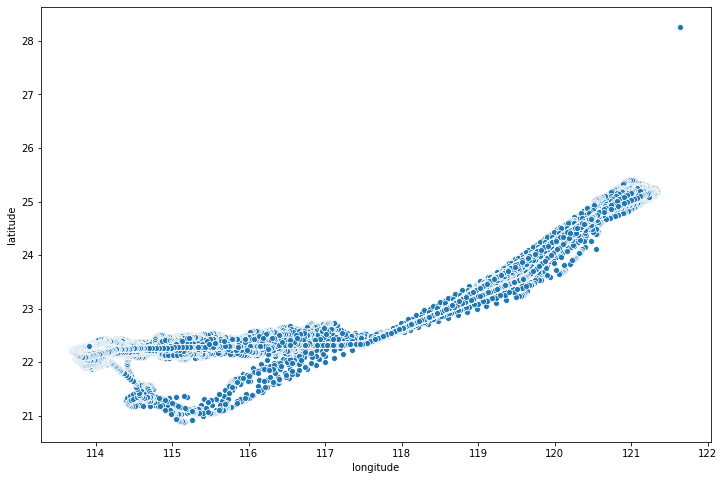

In [93]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(ax = ax, x='longitude', y='latitude', data=combined_arrivals_at_hkg)
plt.show()

In [94]:
combined_arrivals_at_hkg['time_since_real_departure'] = combined_arrivals_at_hkg['timestamp_utc'] - combined_arrivals_at_hkg['real_departure_utc']

In [95]:
combined_arrivals_at_hkg.loc[combined_arrivals_at_hkg['latitude'] > 28, 
                             trails.columns]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed
27371,c31cf95,1484662603,28.258541,121.633163,11600,8,0


In [96]:
combined_arrivals_at_hkg.loc[combined_arrivals_at_hkg['flight_id'] == 'c31cf95', 
                             trails.columns].sort_values(by='timestamp_utc').head(5)

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed
27371,c31cf95,1484662603,28.258541,121.633163,11600,8,0
27372,c31cf95,1484662641,24.921299,120.893318,19450,256,0
27373,c31cf95,1484662667,24.853016,120.848541,20684,230,390
27374,c31cf95,1484662677,24.837517,120.830132,21338,219,454
27375,c31cf95,1484662694,24.831850,120.808067,22190,258,329


In [97]:
combined_arrivals_at_hkg.drop(index=27371, inplace=True)

In [96]:
# combined_arrivals_at_hkg[combined_arrivals_at_hkg['origin'] == 'Taiwan Taoyuan International Airport']

## Shift latitude and longitude by 1 for comparison of distance

In [98]:
unique_flight_ids = combined_arrivals_at_hkg.flight_id.unique().tolist()

df_prev_lat_lon = pd.DataFrame(columns=['flight_id', 'timestamp_utc', 'prev_latitude', 'prev_longitude'])

for flight_id in unique_flight_ids:
    dummy_df = combined_arrivals_at_hkg.loc[combined_arrivals_at_hkg['flight_id'] == flight_id, 
                                            ['flight_id', 'timestamp_utc', 'latitude', 'longitude']]
    dummy_df[['latitude', 'longitude']] = dummy_df[['latitude', 'longitude']].shift(1)
    dummy_df.rename(columns={'latitude': 'prev_latitude',
                             'longitude': 'prev_longitude'}, inplace=True)
    df_prev_lat_lon = pd.concat([df_prev_lat_lon, dummy_df])
df_prev_lat_lon

,flight_id,timestamp_utc,prev_latitude,prev_longitude
87482,c0aabc0,1483193923,NaN,NaN
87483,c0aabc0,1483193942,25.089270,121.240158
87484,c0aabc0,1483194080,25.089512,121.240349
87485,c0aabc0,1483194271,25.089546,121.240372
87486,c0aabc0,1483194304,25.089550,121.240372
...,...,...,...,...
227508,c52959e,1485870339,22.308723,113.916298
227509,c52959e,1485870348,22.308483,113.916603
227510,c52959e,1485870355,22.308449,113.916817
227511,c52959e,1485870366,22.308659,113.916946


In [99]:
merged_df = pd.merge(combined_arrivals_at_hkg,
                     df_prev_lat_lon,
                     how='left',
                     left_on=['flight_id', 'timestamp_utc'],
                     right_on=['flight_id', 'timestamp_utc'])
merged_df.shape

(289711, 57)

In [100]:
# merged_df.to_feather('../data/merged_arrivals_at_hkg.feather')
merged_df.to_feather('../data/merged_twn_to_hkg.feather')

In [101]:
selected_col = trails.columns.tolist()
selected_col.extend(['real_flight_duration', 'real_departure_utc', 'real_departure_dt', 
                     'scheduled_departure_dt', 'scheduled_arrival_dt',
                     'time_since_real_departure', 'estimated_arrival_dt'])

**altitude > 0 but speed <= 0. Possibly erroneous**

In [102]:
merged_df.loc[(merged_df['speed'] <= 0) & (merged_df['altitude'] > 0), 
              'flight_id'].unique()

array(['c31cf95', 'c33e9e8', 'c4490d9'], dtype=object)

In [103]:
merged_df.loc[merged_df['flight_id'] == 'c31cf95'].shape

(68, 57)

In [106]:
# merged_df['scheduled_arrival_dt'].value_counts().sort_index()

In [107]:
# merged_df['real_departure_dt'].value_counts(dropna=False).sort_index()

In [104]:
merged_df.loc[merged_df['flight_id'] == 'c31cf95', selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,scheduled_departure_dt,scheduled_arrival_dt,time_since_real_departure,estimated_arrival_dt
142344,c31cf95,1484662641,24.921299,120.893318,19450,256,0,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,404.0,2017-01-17 15:35:03
142345,c31cf95,1484662667,24.853016,120.848541,20684,230,390,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,430.0,2017-01-17 15:35:03
142346,c31cf95,1484662677,24.837517,120.830132,21338,219,454,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,440.0,2017-01-17 15:35:03
142347,c31cf95,1484662694,24.831850,120.808067,22190,258,329,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,457.0,2017-01-17 15:35:03
142348,c31cf95,1484662709,24.831102,120.788239,22980,287,301,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,472.0,2017-01-17 15:35:03
142349,c31cf95,1484662719,24.845474,120.779282,23427,320,348,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,482.0,2017-01-17 15:35:03
142350,c31cf95,1484662729,24.866079,120.764854,24134,330,404,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,492.0,2017-01-17 15:35:03
142351,c31cf95,1484662736,24.871128,120.760094,24283,319,378,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,499.0,2017-01-17 15:35:03
142352,c31cf95,1484662742,24.881048,120.749977,24514,318,374,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,505.0,2017-01-17 15:35:03
142353,c31cf95,1484662752,24.888002,120.739769,24800,309,352,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,515.0,2017-01-17 15:35:03


In [105]:
merged_df.loc[merged_df['flight_id'] == 'c33e9e8', selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,scheduled_departure_dt,scheduled_arrival_dt,time_since_real_departure,estimated_arrival_dt
152158,c33e9e8,1484740121,25.059814,121.229324,0,225,21,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-304.0,2017-01-18 13:29:31
152159,c33e9e8,1484740373,25.053635,121.227264,0,50,20,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-52.0,2017-01-18 13:29:31
152160,c33e9e8,1484740379,25.054150,121.227951,0,50,46,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-46.0,2017-01-18 13:29:31
152161,c33e9e8,1484740389,25.056210,121.230698,0,50,88,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-36.0,2017-01-18 13:29:31
152162,c33e9e8,1484740399,25.059471,121.234993,0,50,120,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-26.0,2017-01-18 13:29:31
152163,c33e9e8,1484740405,25.061531,121.237564,0,50,140,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-20.0,2017-01-18 13:29:31
152164,c33e9e8,1484740420,25.067184,121.244965,0,49,0,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-5.0,2017-01-18 13:29:31
152165,c33e9e8,1484740426,25.070297,121.248878,50,48,0,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,1.0,2017-01-18 13:29:31
152166,c33e9e8,1484740434,25.076294,121.256813,525,50,0,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,9.0,2017-01-18 13:29:31
152167,c33e9e8,1484740440,25.079367,121.260925,775,51,0,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,15.0,2017-01-18 13:29:31


In [106]:
merged_df.loc[merged_df['flight_id'] == 'c4490d9', selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,scheduled_departure_dt,scheduled_arrival_dt,time_since_real_departure,estimated_arrival_dt
228743,c4490d9,1485359074,24.110689,120.543747,14325,0,0,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,411.0,2017-01-25 17:04:21
228744,c4490d9,1485359127,25.075544,120.854759,22050,343,0,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,464.0,2017-01-25 17:04:21
228745,c4490d9,1485359149,25.054354,120.823624,23325,230,371,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,486.0,2017-01-25 17:04:21
228746,c4490d9,1485359176,25.024464,120.793999,24450,219,471,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,513.0,2017-01-25 17:04:21
228747,c4490d9,1485359182,25.019495,120.780548,25614,219,471,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,519.0,2017-01-25 17:04:21
228748,c4490d9,1485359244,24.922564,120.683693,28925,212,591,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,581.0,2017-01-25 17:04:21
228749,c4490d9,1485359297,24.815313,120.600418,31319,220,533,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,634.0,2017-01-25 17:04:21
228750,c4490d9,1485359338,24.738972,120.536194,33398,244,435,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,675.0,2017-01-25 17:04:21
228751,c4490d9,1485359356,24.718842,120.508430,33900,223,433,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,693.0,2017-01-25 17:04:21
228752,c4490d9,1485359408,24.714375,120.503502,33950,223,433,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,745.0,2017-01-25 17:04:21


In [107]:
# Drop flights with flight_id c4490d9, c31cf95. 
# Reason being that the are multiple records with altitude > 0 but speed = 0 in between records
# merged_df.drop(merged_df[(merged_df['flight_id'].isin(['c4490d9', 'c31cf95']))].index, inplace=True)

In [108]:
# Don't drop because the records with altitude > 0 but speed = 0
# are at the start of the flight
merged_df.loc[(merged_df['flight_id'] == 'c33e9e8'), 
               selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,scheduled_departure_dt,scheduled_arrival_dt,time_since_real_departure,estimated_arrival_dt
152158,c33e9e8,1484740121,25.059814,121.229324,0,225,21,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-304.0,2017-01-18 13:29:31
152159,c33e9e8,1484740373,25.053635,121.227264,0,50,20,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-52.0,2017-01-18 13:29:31
152160,c33e9e8,1484740379,25.054150,121.227951,0,50,46,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-46.0,2017-01-18 13:29:31
152161,c33e9e8,1484740389,25.056210,121.230698,0,50,88,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-36.0,2017-01-18 13:29:31
152162,c33e9e8,1484740399,25.059471,121.234993,0,50,120,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-26.0,2017-01-18 13:29:31
152163,c33e9e8,1484740405,25.061531,121.237564,0,50,140,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-20.0,2017-01-18 13:29:31
152164,c33e9e8,1484740420,25.067184,121.244965,0,49,0,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,-5.0,2017-01-18 13:29:31
152165,c33e9e8,1484740426,25.070297,121.248878,50,48,0,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,1.0,2017-01-18 13:29:31
152166,c33e9e8,1484740434,25.076294,121.256813,525,50,0,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,9.0,2017-01-18 13:29:31
152167,c33e9e8,1484740440,25.079367,121.260925,775,51,0,5746.0,1.484740e+09,2017-01-18 11:53:45,2017-01-18 11:40:00,2017-01-18 13:40:00,15.0,2017-01-18 13:29:31


## Filter flights from TWN that landed in HKG

In [109]:
unique_flight_ids = merged_df['flight_id'].unique()
incomplete_flights = []
complete_flights = []
filtered_df = pd.DataFrame(columns=merged_df.columns.tolist() + ['calculated_flight_duration'])

for unique_flight_id in unique_flight_ids:
    # Filter to get records where 
    # plane has taken off; i.e. speed > 0
    # plane's time_since_real_departure >= 0
    temp = merged_df.loc[(merged_df['flight_id'] == unique_flight_id) &
                         (merged_df['time_since_real_departure'] >= 0) &
                         (merged_df['speed'] > 0)].sort_values(by='timestamp_utc')
#                          , selected_col].sort_values(by='timestamp_utc')
    
    # time_since_real_departure after arrival 
    # where altitude = 0
#     if 0 in temp['altitude'][:10]:
#         print("ZERO ALTITUDE IN FIRST 10")
    possible_arrival_df = temp.loc[(temp['altitude'] == 0) & 
                                   (temp['time_since_real_departure'] > 11)] # setting to 0 will reveal that some planes did not take off successfully at the first attempt; > 0 then back to 0
    
    if possible_arrival_df.shape[0] > 0:
        complete_flights.append(unique_flight_id)
        calculated_flight_duration = possible_arrival_df.iloc[0]['time_since_real_departure']
        temp = temp[temp['time_since_real_departure'] <= calculated_flight_duration]
        temp = temp.assign(calculated_flight_duration=calculated_flight_duration)
        filtered_df = filtered_df.append(temp, ignore_index=True)
    else:
        incomplete_flights.append(unique_flight_id)

print("Number of complete flights: {}".format(len(complete_flights)))
print("Number of incomplete flights: {}".format(len(incomplete_flights)))

Number of complete flights: 788
Number of incomplete flights: 362


In [110]:
filtered_df.head()

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,route,scheduled_flight_duration,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals,timestamp,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS,speed_interval,time_since_real_departure,prev_latitude,prev_longitude,calculated_flight_duration
0,c0aabc0,1483194745,25.090073,121.237190,950,46,143,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,2016-12-31 15:49:48,Taiwan Taoyuan International Airport -> Hong K...,5400.0,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500.0,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,20.0,25.072781,121.218529,5115.0
1,c0aabc0,1483194754,25.093964,121.242012,1375,48,145,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,2016-12-31 15:49:48,Taiwan Taoyuan International Airport -> Hong K...,5400.0,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500.0,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,29.0,25.090073,121.237190,5115.0
2,c0aabc0,1483194770,25.101013,121.251183,2100,50,153,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,2016-12-31 15:49:48,Taiwan Taoyuan International Airport -> Hong K...,5400.0,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500.0,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,45.0,25.093964,121.242012,5115.0
3,c0aabc0,1483194776,25.103577,121.254631,2300,50,159,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,2016-12-31 15:49:48,Taiwan Taoyuan International Airport -> Hong K...,5400.0,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500.0,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,51.0,25.101013,121.251183,5115.0
4,c0aabc0,1483194782,25.107010,121.259155,2525,50,171,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,2016-12-31 15:49:48,Taiwan Taoyuan International Airport -> Hong K...,5400.0,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500.0,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,57.0,25.103577,121.254631,5115.0


In [111]:
filtered_df.dtypes

flight_id                                   object
timestamp_utc                               object
latitude                                   float64
longitude                                  float64
altitude                                    object
heading                                     object
speed                                       object
flight_callsign                             object
aircraft_model                              object
aircraft_registration                       object
airline                                     object
origin                                      object
destination                                 object
scheduled_departure_utc                    float64
scheduled_arrival_utc                      float64
real_departure_utc                         float64
estimated_arrival_utc                      float64
real_flight_duration                       float64
scheduled_departure_dt              datetime64[ns]
scheduled_arrival_dt           

In [112]:
# Convert to int
for col in ['altitude', 'heading', 'speed', 'timestamp_utc', 'arrivals', 'wind_dir', 'gust_speed'
#            'scheduled_arrival_year', 'scheduled_arrival_month', 
#             'scheduled_arrival_day', 'scheduled_departure_year', 
#             'scheduled_departure_month', 'scheduled_departure_day'
           ]:
    filtered_df[col] = filtered_df[col].astype(int)

In [113]:
filtered_df['calculated_flight_duration'].value_counts().sort_index()

4274.0    141
4503.0    185
4551.0    162
4590.0    176
4593.0    185
         ... 
6781.0    314
6833.0    317
6882.0    281
6930.0    316
6973.0    356
Name: calculated_flight_duration, Length: 632, dtype: int64

In [114]:
filtered_df['calculated_time_before_arrival'] = filtered_df['calculated_flight_duration'] - filtered_df['time_since_real_departure']

In [115]:
hkg_lat, hkg_lon = 22.308046, 113.918480
twn_lat, twn_lon = 25.0725, 121.2210

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

filtered_df['displacement_to_hkg'] = filtered_df.apply(lambda x: haversine(x.longitude,
                                                                           x.latitude,
                                                                           hkg_lon, hkg_lat), 
                                                                     axis=1)

filtered_df['displacement_fr_twn'] = filtered_df.apply(lambda x: haversine(x.longitude,
                                                                           x.latitude,
                                                                           twn_lon, twn_lat), 
                                                                     axis=1)

In [116]:
(filtered_df['time_since_real_departure'] / 60).max()

116.21666666666667

In [117]:
cut_labels = ['0 <= min <= 10', 
              '10 < min <= 20',
              '20 < min <=30',
              '30 < min <= 40',
              '40 < min <= 50',
              '50 < min <= 60',
              '60 < min <= 70',
              '70 < min <= 80',
              '80 < min <= 90',
              '90 < min <= 100',
              '100 < min <= 110',
              '110 < min <= 120'
             ]
cut_bins = [-np.inf, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
filtered_df['minutes_since_real_departure_interval'] = pd.cut((filtered_df['time_since_real_departure'] / 60), 
                                                               bins=cut_bins, labels=cut_labels)

In [118]:
filtered_df['minutes_since_real_departure_interval'].value_counts().sort_index()

0 <= min <= 10      29067
10 < min <= 20       8202
20 < min <=30        8881
30 < min <= 40       7532
40 < min <= 50       8446
50 < min <= 60       8480
60 < min <= 70      14669
70 < min <= 80      34607
80 < min <= 90      32189
90 < min <= 100     15485
100 < min <= 110     3880
110 < min <= 120      328
Name: minutes_since_real_departure_interval, dtype: int64

In [119]:
filtered_df.groupby(['minutes_since_real_departure_interval', 'flight_id'])['displacement_fr_twn'] \
.max().reset_index()

,minutes_since_real_departure_interval,flight_id,displacement_fr_twn
0,0 <= min <= 10,c0aabc0,53.937310
1,0 <= min <= 10,c0ab750,63.586828
2,0 <= min <= 10,c0ac71c,74.637064
3,0 <= min <= 10,c0b5e1f,58.459735
4,0 <= min <= 10,c0b6e4a,50.094154
...,...,...,...
9451,110 < min <= 120,c524f43,NaN
9452,110 < min <= 120,c5285c7,NaN
9453,110 < min <= 120,c528666,NaN
9454,110 < min <= 120,c528860,NaN


In [120]:
filtered_df['calculated_flight_duration'].sort_values() / 60

23979      71.233333
23960      71.233333
23961      71.233333
23962      71.233333
23963      71.233333
             ...    
131220    116.216667
131219    116.216667
131218    116.216667
131238    116.216667
131172    116.216667
Name: calculated_flight_duration, Length: 171766, dtype: float64

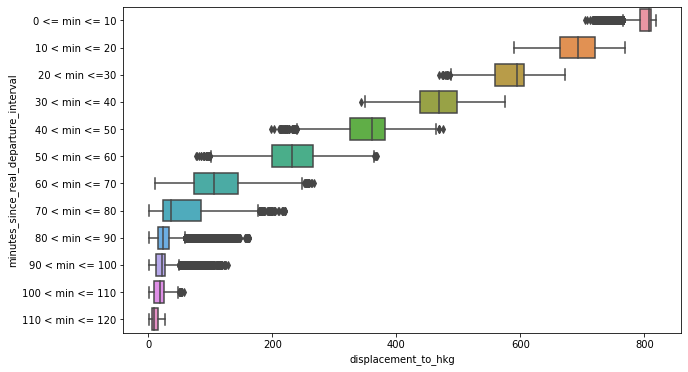

In [121]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='displacement_to_hkg',
            y='minutes_since_real_departure_interval',
            data=filtered_df)
plt.show()

In [122]:
filtered_df.dtypes

flight_id                                        object
timestamp_utc                                     int64
latitude                                        float64
longitude                                       float64
altitude                                          int64
heading                                           int64
speed                                             int64
flight_callsign                                  object
aircraft_model                                   object
aircraft_registration                            object
airline                                          object
origin                                           object
destination                                      object
scheduled_departure_utc                         float64
scheduled_arrival_utc                           float64
real_departure_utc                              float64
estimated_arrival_utc                           float64
real_flight_duration                            

In [123]:
numeric_features = filtered_df.dtypes[(filtered_df.dtypes == np.int)|(filtered_df.dtypes == np.float)]
numeric_features = numeric_features.index.tolist()
numeric_features.remove('calculated_time_before_arrival')
print(numeric_features)
target_col = 'calculated_time_before_arrival'

['timestamp_utc', 'latitude', 'longitude', 'altitude', 'heading', 'speed', 'scheduled_departure_utc', 'scheduled_arrival_utc', 'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration', 'scheduled_flight_duration', 'arrivals', 'air_temp', 'dewpoint_temp', 'rel_humidity', 'wind_dir', 'wind_speed', 'altimeter_pressure', 'visibility', 'gust_speed', 'sky_level_1_altitude', 'apparent_temp', 'weather_codes_+SHRA', 'weather_codes_+TSRA', 'weather_codes_-BR', 'weather_codes_-DZ', 'weather_codes_-RA', 'weather_codes_-SHRA', 'weather_codes_BR', 'weather_codes_DZ', 'weather_codes_HZ', 'weather_codes_RA', 'weather_codes_SHRA', 'weather_codes_TSRA', 'weather_codes_VCTS', 'time_since_real_departure', 'prev_latitude', 'prev_longitude', 'calculated_flight_duration', 'displacement_to_hkg', 'displacement_fr_twn']


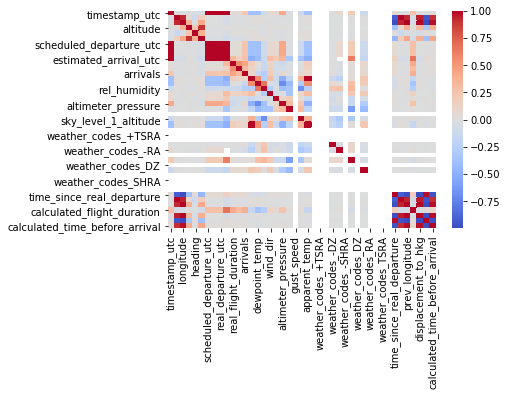

In [124]:
sns.heatmap(filtered_df[numeric_features + [target_col]].corr(), annot=False, cmap='coolwarm')

## Callsign

In [125]:
# df_twn_hkg_with_flight_dur = pd.merge(df_twn_to_hkg,
#                                       filtered_df[['flight_id', 'calculated_flight_duration']],
#                                       on='flight_id').drop_duplicates()

In [126]:
df_twn_hkg_with_flight_dur = filtered_df

In [127]:
df_twn_hkg_with_flight_dur['flight_callsign'] = df_twn_hkg_with_flight_dur['flight_callsign'].str.extract(r'([A-Z]*)')
df_twn_hkg_with_flight_dur['flight_callsign'].value_counts()

CPA    63943
CAL    41217
EVA    34877
CRK    18069
HDA     6243
AHK     3959
FDX     1236
PAC      733
UPS      648
BR       420
NCA      230
HX       191
Name: flight_callsign, dtype: int64

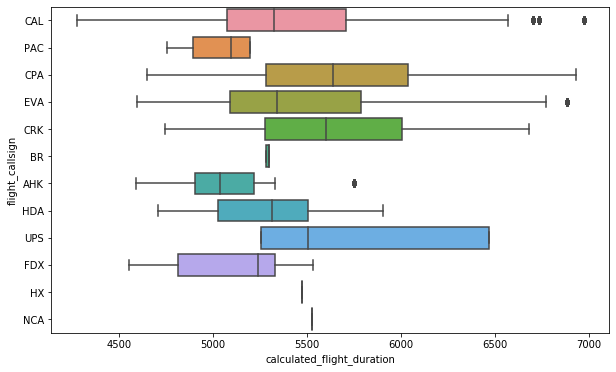

In [128]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='flight_callsign',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()

## Airline

In [129]:
df_twn_hkg_with_flight_dur['airline'].value_counts(dropna=False).values.sum()

171766

In [130]:
# set(df_twn_hkg_with_flight_dur['airline'].value_counts(dropna=False).index.map(lambda x: re.sub(r'\([^)]*\)', '', x).strip()))

In [131]:
df_twn_hkg_with_flight_dur['airline'] = df_twn_hkg_with_flight_dur['airline'].map(lambda x: re.sub(r'\([^)]*\)', '', x).strip())

In [132]:
df_twn_hkg_with_flight_dur['airline'].value_counts()

Cathay Pacific           59224
China Airlines           33925
EVA Air                  28509
Hong Kong Airlines       18260
China Airlines Cargo      6696
Cathay Dragon             6243
Air Hong Kong             5135
EVA Air Cargo             4810
Cathay Pacific Cargo      2745
Eva Air                   1978
FedEx                     1236
                          1038
Polar Air Cargo            733
UPS                        648
Mandarin Airlines          356
Nippon Cargo Airlines      230
Name: airline, dtype: int64

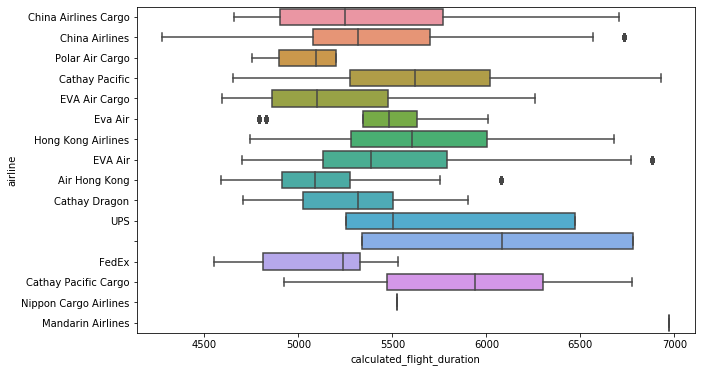

In [133]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='airline',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()

## Aircraft Model

In [134]:
df_twn_hkg_with_flight_dur.aircraft_model.value_counts().sort_index()

                             1038
Airbus A3004F-605R            939
Airbus A300B4-622R(F)         743
Airbus A300F4-605R           3453
Airbus A320-232              2389
Airbus A321-211             25114
Airbus A321-231              2249
Airbus A330-203              1721
Airbus A330-223              3663
Airbus A330-243              4533
Airbus A330-243F             2046
Airbus A330-302             13200
Airbus A330-342              7572
Airbus A330-343             33232
Airbus A340-313              5793
Airbus A350-941             20118
Boeing 737-809               1563
Boeing 737-8AL               1866
Boeing 737-8FH                278
Boeing 737-8MA                859
Boeing 737-8Q8                374
Boeing 737-8SH                356
Boeing 747-409                202
Boeing 747-409(F)            6696
Boeing 747-412(BCF)           274
Boeing 747-45E                224
Boeing 747-45E(BDSF)         2403
Boeing 747-45EF(SCD)         2407
Boeing 747-467F(ER)          2107
Boeing 747-46N

In [135]:
def get_aircraft_model(aircraft):
    if aircraft.find('Airbus') != -1:
        return aircraft[:11]
    elif aircraft.find('Boeing') != -1:
        return aircraft[:10]
    else:
        return aircraft
    
df_twn_hkg_with_flight_dur.aircraft_model = df_twn_hkg_with_flight_dur.aircraft_model.map(get_aircraft_model)

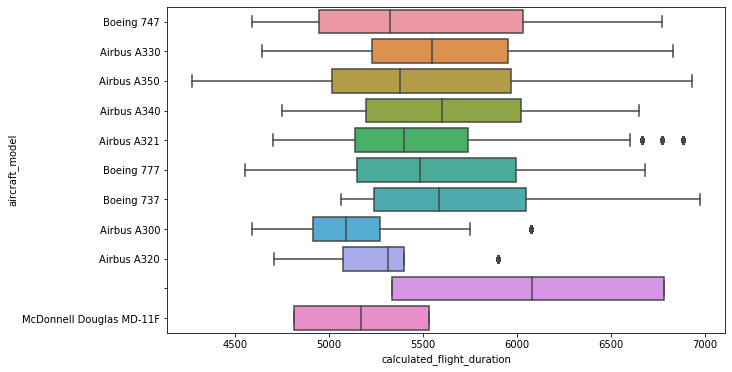

In [136]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='aircraft_model',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()

## Aircraft Registration

In [137]:
df_twn_hkg_with_flight_dur.aircraft_registration.value_counts().sort_index()

           1038
B-16201     417
B-16203    1950
B-16206    1277
B-16208     211
B-16212     213
B-16215    1628
B-16216    2203
B-16217     799
B-16218    1978
B-16219    2085
B-16220     679
B-16221    2982
B-16222    1454
B-16223    1806
B-16225    2246
B-16226    2177
B-16227    1009
B-16310     496
B-16311     218
B-16312    1007
B-16335     345
B-16336     202
B-16401     469
B-16406    1934
B-16410     224
B-16481    1148
B-16482     649
B-16483     610
B-16701     220
B-16702     722
B-16703     509
B-16708     174
B-16710     454
B-16712     228
B-16716     207
B-16717     367
B-18001     190
B-18007     204
B-18051     189
B-18053     205
B-18208     202
B-18301    1814
B-18302     928
B-18303     220
B-18306     189
B-18307     412
B-18308     384
B-18309    2589
B-18310     737
B-18312     445
B-18315     208
B-18316     201
B-18317     438
B-18351    1416
B-18352     767
B-18353     803
B-18355     443
B-18358     213
B-18359     228
B-18360     218
B-18605     231
B-18606 

In [138]:
selected_features = ['latitude', 'longitude', 'altitude', 'heading', 'speed',
#                      'flight_callsign', 
#                      'aircraft_registration', 
                     'aircraft_model', 'airline']

nominal_features = [
    'flight_callsign', 
    'aircraft_registration',
    'aircraft_model', 
    'airline'
]

In [139]:
df_twn_hkg_with_flight_dur.columns

Index(['flight_id', 'timestamp_utc', 'latitude', 'longitude', 'altitude',
       'heading', 'speed', 'flight_callsign', 'aircraft_model',
       'aircraft_registration', 'airline', 'origin', 'destination',
       'scheduled_departure_utc', 'scheduled_arrival_utc',
       'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration',
       'scheduled_departure_dt', 'scheduled_arrival_dt', 'real_departure_dt',
       'estimated_arrival_dt', 'route', 'scheduled_flight_duration',
       'forecasted_arrival_dt', 'forecasted_arrival_dt_nearest_hr', 'arrivals',
       'timestamp', 'air_temp', 'dewpoint_temp', 'rel_humidity', 'wind_dir',
       'wind_speed', 'altimeter_pressure', 'visibility', 'gust_speed',
       'sky_level_1_coverage', 'sky_level_1_altitude', 'weather_codes',
       'apparent_temp', 'weather_codes_+SHRA', 'weather_codes_+TSRA',
       'weather_codes_-BR', 'weather_codes_-DZ', 'weather_codes_-RA',
       'weather_codes_-SHRA', 'weather_codes_BR', 'weather_codes_DZ',


In [140]:
corr = filtered_df[numeric_features + [target_col]].corr()[target_col].sort_values()
corr[abs(corr.values) > 0.38]

displacement_fr_twn              -0.977494
time_since_real_departure        -0.964894
altitude                          0.388276
speed                             0.434193
latitude                          0.910920
prev_latitude                     0.915070
displacement_to_hkg               0.977985
prev_longitude                    0.981058
longitude                         0.981073
calculated_time_before_arrival    1.000000
Name: calculated_time_before_arrival, dtype: float64

## Save Data

In [141]:
filtered_df['flight_callsign'] = filtered_df['flight_callsign'].str.extract(r'([A-Z]*)')
filtered_df['airline'] = filtered_df['airline'].map(lambda x: re.sub(r'\([^)]*\)', '', x).strip())
filtered_df['aircraft_model'] = filtered_df.aircraft_model.map(get_aircraft_model)

In [142]:
filtered_df.to_csv('../data/filtered_flights_twn_hkg.csv')

## Plot of all flights that did not fly a holding pattern (Taiwan Taoyuan International Airport -> Hong Kong International Airport)

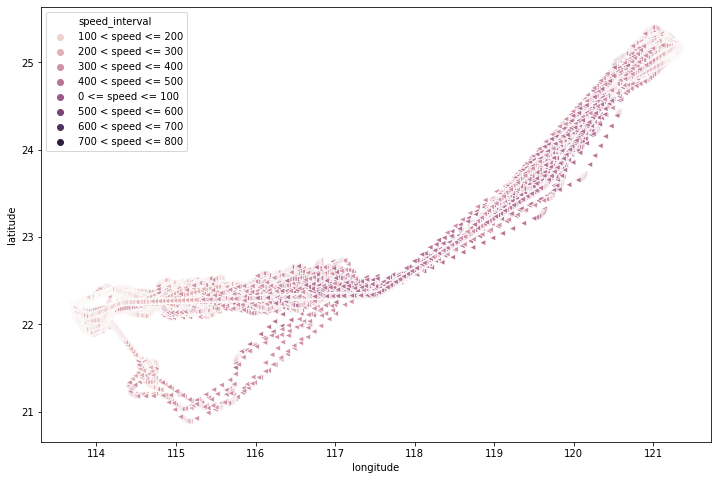

In [143]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(ax = ax, x='longitude', y='latitude', hue='speed_interval', marker='<',
#                 palette=sns.color_palette("Blues", 8),
                palette=sns.cubehelix_palette(8),
                data=filtered_df)
plt.show();

In [ ]:
# holding_stack_flight_ids = combined_jkt_sin.loc[combined_jkt_sin['latitude'] > 1.5, 'flight_id'].unique().tolist()

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(ax = ax, x='longitude', y='latitude', hue='speed_interval', marker='<',
# #                 palette=sns.color_palette("Blues", 8),
#                 palette=sns.cubehelix_palette(8),
#                 data=combined_jkt_sin[~combined_jkt_sin['flight_id'].isin(holding_stack_flight_ids)])
# plt.show();